# Защита персональных данных клиентов
## Постановка задачи
Необходимо защитить данные клиентов страховой компании «Хоть потоп». Нужно разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. После этого нужно обосновать корректность его работы и проверить на практике.

Нужно защитить данные так, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

## Импорт библиотек

In [344]:
from pathlib import Path

import pandas as pd
pd.set_option('display.float_format', '{:,.4f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## Загрузка и первичное исследование данных
### Загрузка данных
Загрузим датасет с данными клиентов компании и ознакомимся с данными. Датасет содержит 5 тысяч строк. Пропусков нет. 

Обучающие признаки: 
* пол, 
* возраст, 
* зарплата застрахованного, 
* количество членов его семьи.

Целевой признак: 
* количество страховых выплат клиенту за последние 5 лет.

Страховыми выплатами пользуется порядка 7.04% клиентов. 

Данные пригодны для дальнейшего исследования.

In [345]:
my_path = Path('/home/klarazetkin/Documents/yandex/module_4/project_1')
file_name = str(my_path) + '/' + 'insurance.csv'
if my_path.is_dir():
    df = pd.read_csv(file_name)
else:
    df = pd.read_csv('/datasets/insurance.csv')

### Первичное исследование данных
#### Структура и диапазон значений

In [346]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0000,"49,600.0000",1,0
1,0,46.0000,"38,000.0000",1,1
2,0,29.0000,"21,000.0000",0,0
3,0,21.0000,"41,700.0000",2,0
4,1,28.0000,"26,100.0000",0,0


In [347]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,"5,000.0000","5,000.0000","5,000.0000","5,000.0000","5,000.0000"
mean,0.4990,30.9528,"39,916.3600",1.1942,0.1480
std,0.5000,8.4408,"9,900.0836",1.0914,0.4632
min,0.0000,18.0000,"5,300.0000",0.0000,0.0000
25%,0.0000,24.0000,"33,300.0000",0.0000,0.0000
50%,0.0000,30.0000,"40,200.0000",1.0000,0.0000
75%,1.0000,37.0000,"46,600.0000",2.0000,0.0000
max,1.0000,65.0000,"79,000.0000",6.0000,5.0000


In [348]:
payout_starts_procentile = stats.percentileofscore(df['Страховые выплаты'], 1)

print('Процентиль, с которого начинаются страховые выплаты: ', 
      round(payout_starts_procentile, 2))

print('Выплаты получают: ', round((100 - payout_starts_procentile), 2))

Процентиль, с которого начинаются страховые выплаты:  92.96
Выплаты получают:  7.04


#### Проверка корреляции признаков
Проверим корреляцию признаков в датафрейме. Наблюдается сильная положительная корреляция целевого признака (количества страховых выплат) с возрастом клиента. Коэффициент корреляции 0.65. Других значимых корреляций не выявлено.

In [349]:
# функция печати тепловой карты коэффициентов корреляции
def correlation_heatmap(dataframe):
    plt.figure(figsize=(18, 7))

    sns.heatmap(dataframe, annot=True, fmt=".5f", linewidths=.1, cmap= 'coolwarm')
    plt.title('Матрица коэффициентов корреляции', fontsize=15)
    plt.ylabel('Признак', fontsize=15)
    plt.xlabel('Признак', fontsize=15)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.0000,0.0021,0.0149,-0.0090,0.0101
Возраст,0.0021,1.0000,-0.0191,-0.0067,0.6510
Зарплата,0.0149,-0.0191,1.0000,-0.0303,-0.0150
Члены семьи,-0.0090,-0.0067,-0.0303,1.0000,-0.0363
Страховые выплаты,0.0101,0.6510,-0.0150,-0.0363,1.0000


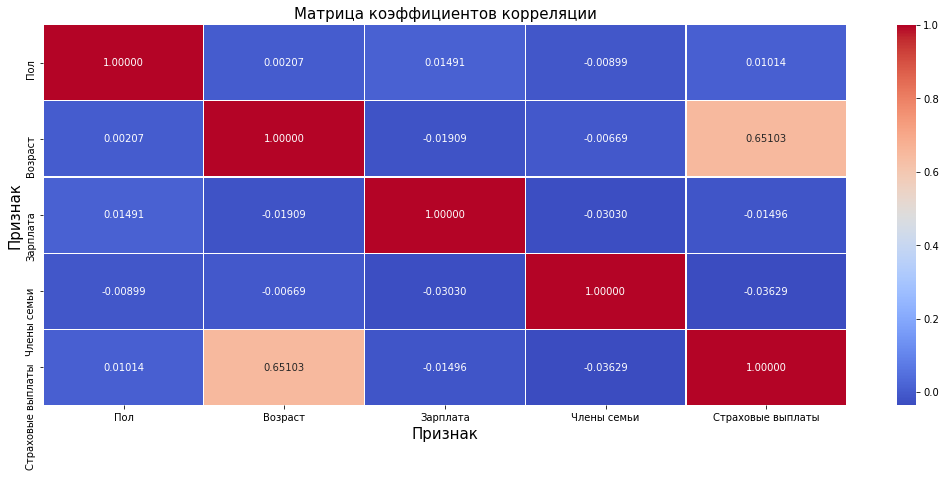

In [350]:
display(df.corr())
correlation_heatmap(df.corr())

In [351]:
# функция печати матрицы диаграмм рассеяния
def scatter_matrix(dataframe):
    pd.plotting.scatter_matrix(
        dataframe, 
        figsize=(12, 12)
    )

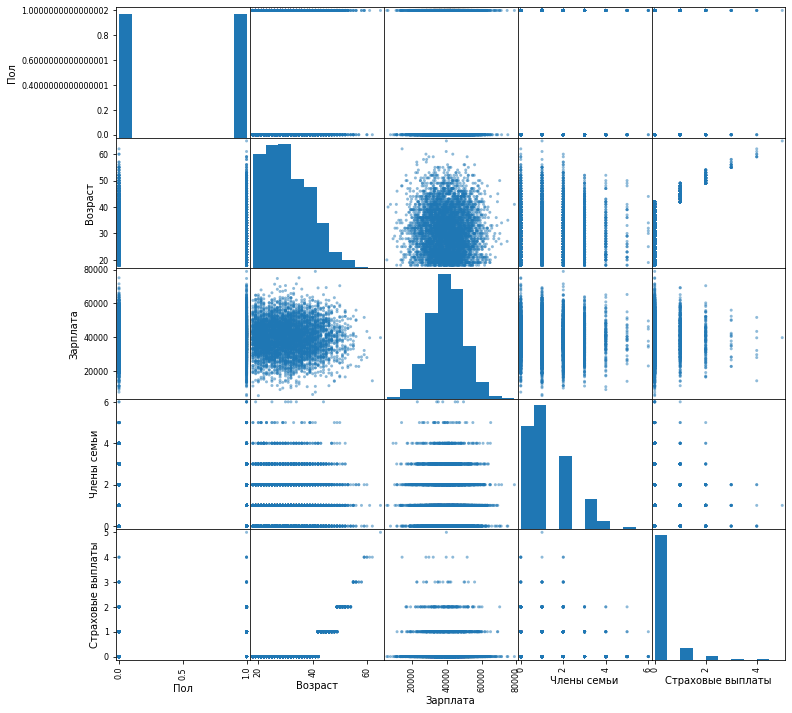

In [352]:
scatter_matrix(df)

## Подготовка данных
### Переименование столбцов
Приведем названия столбцов в стандартный вид.

In [353]:
df = df.rename(
    columns={'Пол': 'gender', 
             'Возраст': 'age', 
             'Зарплата': 'salary', 
             'Члены семьи': 'relatives', 
             'Страховые выплаты': 'payouts_count'})

### Изменение типа столбцов
Возраст и зарплата указаны в типе float, эта точность избыточна. Приведем значения к целочисленному типу. Но перед этим проверим, что нет потери данных по зарплате от округления.

In [354]:
# добавим колонку salary_check, в которую запишем дробную часть из колонки salary
df['salary_check'] = df['salary'] % 1
# display(df['salary_check'].describe())
salary_not_even_procentile = round(100 - stats.percentileofscore(df['salary_check'], 0.01), 2)
print('Зарплаты с дробной частью составляют', salary_not_even_procentile, '%')

Зарплаты с дробной частью составляют 0.06 %


In [355]:
print('Всего зарплат с ненулевой дробной частью:', df[df['salary_check'] > 0]['salary'].count())
print('Всего зарплат с дробной частью > 0.1:', df[df['salary_check'] > 0.1]['salary'].count())
print(df[df['salary_check'] > 0]['salary'].describe())
print(
  '''Делаем вывод, что все зарплаты указаны в рублях, \
  потери информации от конвертации в тип integer не будет''')

Всего зарплат с ненулевой дробной частью: 40
Всего зарплат с дробной частью > 0.1: 3
count       40.0000
mean    36,515.0000
std     10,799.7994
min     32,200.0000
25%     32,200.0000
50%     32,700.0000
75%     32,700.0000
max     65,100.0000
Name: salary, dtype: float64
Делаем вывод, что все зарплаты указаны в рублях,   потери информации от конвертации в тип integer не будет


In [356]:
# удаляем колонку
df = df.drop('salary_check', axis=1)
# конвертируем типы
df['age'] = df['age'].astype('int')
df['salary'] = round(df['salary']).astype('int')

### Проверка на пустые значения
Пустые значения отсутствуют.

In [357]:
df.isna().mean()

gender          0.0000
age             0.0000
salary          0.0000
relatives       0.0000
payouts_count   0.0000
dtype: float64

## Обоснование алгоритма шифрования данных

Для шифрования данных предлагается умножить датасет с признаками на обратимую матрицу. Предполагается, что качество предсказаний модели, обученной на зашифрованном датасете, будет таким же, как у модели, обученной на исходном датасете.

Исследуемый вопрос: изменится ли качество линейной регрессии? 

Ответ: качество предсказаний не изменится. 

Обоснование: воспользуемся свойствами матриц, чтобы доказать предположение.

Свойства матриц:

$$
E A = A E = A
$$

$$
A A^{-1} = A^{-1} A = E
$$

$$
(A B)^T = B^T A^T
$$

$$
(A B)^{-1} = B^{-1} A^{-1}
$$

$$
(A^T)^{-1} = (A^{-1})^T
$$

Обозначения:

𝑋  — матрица признаков (нулевой столбец состоит из единиц)

𝑦  — вектор целевого признака

𝑃  — матрица, на которую умножаются признаки

𝑤  — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$


Зашифрованная матрица - это исходная матрица, умноженная на обратимую квадратную матрицу $P$:

$$
Xmod = XP
$$

Тогда вектор весов $wmod$ будет равен:

$$
wmod = (Xmod^T Xmod)^{-1} Xmod^T y = 
$$

$$
= ((XP)^T (XP))^{-1} (XP)^T y = 
$$

$$
= ((P^T X^T X P))^{-1} (X P)^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} (P^T)^{-1} (X P)^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} (P^{-1})^T (X P)^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} (P^{-1})^T P^T X^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} (P P^{-1})^T  X^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} E X^T y = 
$$

$$
= P^{-1} (X^T X)^{-1} X^T y = 
$$

$$
= P^{-1} w
$$

Вектор предсказаний $amod$ будет равен:

$$
amod = Xmod  wmod = (X P) (P^{-1} w) = X P P^{-1} w = X E w = X w = a
$$

В итоге преобразований получили, что предсказания $amod$, полученные на основе преобразованной матрицы $Xmod = X P$, будут тождественны предсказаниям $a$, полученным на основе исходных данных в матрице $X$. Следовательно, не изменится и метрика качества модели, обученной на преобразованных данных, по сравнению с метрикой модели, обученной на исходных данных. 

Стоить отметить, что преобразование не получилось бы, если бы матрица $P$ была необратимой, т.к. в процессе преобразования было использовано свойство обратимых матриц  $𝐴 𝐴^{−1} =𝐴^{−1} 𝐴 = 𝐸$ : при умножении матриц, обратных друг к другу, получается единичная матрица. 

Матрицы $((𝑃^𝑇 𝑋^𝑇 𝑋 𝑃))^{−1}$ и $(X^T X)^{-1}$ существуют, так как они квадратные.

## Проверка алгоритма
### Алгоритм шифрования данных клиентов
Для шифрования данных предлагается умножить тренировочный и тестовый датасеты с обучающими признаками (`df_train_target` и `df_test_target`) на случайную обратимую матрицу. Алгоритм преобразования обоснован в предыдущем разделе.

Для проверки алгоритма сначала обучим модель на исходных данных, затем новую модель обучим на преобразованных данных и сравним метрики качества двух моделей. Ожидается, что метрика качества останется неизменной.


### Подготовка незашифрованных датасетов
Подготовим обучающий и тестовый датасеты.

In [358]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=666)
target = 'payouts_count'
df_train_features = df_train.drop('payouts_count', axis=1)
df_train_target = df_train['payouts_count']
df_test_features = df_test.drop('payouts_count', axis=1)
df_test_target = df_test['payouts_count']

### Обучение модели на незашифрованных данных
Инициируем модель линейной регрессии, обучим ее на исходных данных, вычислим метрику качества.

In [359]:
model_original = LinearRegression()
model_original.fit(df_train_features, df_train_target)
predictions_original = model_original.predict(df_test_features)
# print(type(predictions_original))
r2_original = r2_score(df_test_target, predictions_original)
print(r2_original)

0.4102174267727613


In [360]:
predictions_original

array([ 0.94146553,  0.17966114, -0.17200627, ..., -0.07341957,
        0.43099   ,  0.13104485])

### Обучение модели на преобразованных данных
Зашифруем исходные данные: умножим обучающую и тестовую матрицы с нецелевыми признаками (`df_train_features`, `df_test_features`) на обратимую матрицу. 

Для этого создадим обратимую матрицу с длиной строки/столбца, равной длине строки исходной матрицы.

Заново обучим модель на основании зашифрованных данных, сравним ее метрику качества с метрикой качества модели, обученной на исходных данных.

In [361]:
np.random.seed(666)
# функция для генерации обратимой матрицы заданного размера
def generate_invertable_matrix_of_size(size):
    random_matrix = np.random.normal(loc=0.0, scale=1.0, size=(size, size))
    try: 
        inverted_random_matrix = np.linalg.inv(random_matrix)
        return random_matrix
    except:
        return generate_invertable_matrix_of_size(size)

# сгенерируем обратимую матрицу заданного размера
random_matrix = generate_invertable_matrix_of_size(len(df_train_features.columns))
print('Сгенерирована матрица:')
display(random_matrix)

# проверим, что полученная матрица действительно обратима
inverted_random_matrix = np.linalg.inv(random_matrix)
print('Результат обращения этой матрицы:')
display(inverted_random_matrix)

# проверим, что при перемножении получается единичная матрица
multiplied = random_matrix.dot(inverted_random_matrix)
print('Результат перемножения двух матриц:')
np.around(multiplied)

Сгенерирована матрица:


array([[ 0.82418808,  0.479966  ,  1.17346801,  0.90904807],
       [-0.57172145, -0.10949727,  0.01902826, -0.94376106],
       [ 0.64057315, -0.78644317,  0.60886999, -0.93101185],
       [ 0.97822225, -0.73691806, -0.29873262, -0.46058737]])

Результат обращения этой матрицы:


array([[ 0.98823887,  1.25423142, -1.12854185,  1.66167752],
       [ 1.79627512,  3.24637076, -2.55435929,  2.05659322],
       [ 0.04784622, -0.49971764,  1.06163179, -1.02756444],
       [-0.80610885, -2.20611824,  1.00142716, -1.26595686]])

Результат перемножения двух матриц:


array([[ 1., -0.,  0., -0.],
       [ 0.,  1.,  0.,  0.],
       [-0., -0.,  1., -0.],
       [-0., -0., -0.,  1.]])

In [362]:
# преобразуем датасеты путем умножения на случайную матрицу
cyphered_df_train_features = df_train_features.dot(random_matrix)
cyphered_df_test_features = df_test_features.dot(random_matrix)
display(cyphered_df_train_features.head())
display(cyphered_df_test_features.head())

# размерность зашифрованных матриц соответствует размерности исходных матриц
print('Размерность исходной матрицы df_train_features:', df_train_features.shape)
print('Размерность зашифрованной матрицы cyphered_df_train_features:', cyphered_df_train_features.shape)
print('Размерность исходной матрицы df_test_features:', df_test_features.shape)
print('Размерность зашифрованной матрицы cyphered_df_test_features:', cyphered_df_test_features.shape)

,0,1,2,3
4690,"29,387.5190","-36,103.3467","27,946.8264","-42,764.0822"
2483,"33,933.3127","-41,685.3585","32,271.6123","-49,374.3236"
2912,"30,019.6928","-36,888.3037","28,557.9753","-43,703.1846"
4503,"23,609.1350","-29,025.1184","22,468.2351","-34,400.5815"
4864,"27,727.9113","-34,056.5436","26,363.8348","-40,331.6657"


,0,1,2,3
1778,"21,430.8558","-26,353.1234","20,397.5558","-31,239.8374"
4083,"22,852.9471","-28,080.5190","21,737.8437","-33,267.3355"
4613,"30,993.1192","-38,067.7323","29,469.1288","-45,082.6574"
1221,"31,947.8552","-39,247.6456","30,382.9038","-46,487.2084"
1320,"20,674.2615","-25,407.6776","19,667.4440","-30,105.1871"


Размерность исходной матрицы df_train_features: (3000, 4)
Размерность зашифрованной матрицы cyphered_df_train_features: (3000, 4)
Размерность исходной матрицы df_test_features: (2000, 4)
Размерность зашифрованной матрицы cyphered_df_test_features: (2000, 4)


In [363]:
# обучим новую модель на зашифрованных данных
model_cyphered = LinearRegression()
model_cyphered.fit(cyphered_df_train_features, df_train_target)
predictions_cyphered = model_cyphered.predict(cyphered_df_test_features)
r2_cyphered = r2_score(df_test_target, predictions_cyphered)
print(r2_cyphered)

0.41021742677198336


### Вывод по практической проверке алгоритма
Шифрование данных путем умножения на рандомную обратимую матрицу не сказалось на качестве предсказаний модели. Метрика `r2` для обеих моделей совпадает с точностью до 10го знака после запятой.

In [364]:
print('Точное сравнение метрик: ', r2_original == r2_cyphered)
print('Сравнение округленных метрик: ', (round(r2_original, 10) == round(r2_cyphered, 10)))
print('R2 модели, обученной на оригинальных данных: ', r2_original)
print('R2 модели, обученной на зашифрованных данных: ', r2_cyphered)


Точное сравнение метрик:  False
Сравнение округленных метрик:  True
R2 модели, обученной на оригинальных данных:  0.4102174267727613
R2 модели, обученной на зашифрованных данных:  0.41021742677198336


## Возможность дешифровки закодированного датасета
При наличии ключа не составит труда декодировать зашифрованный датасет $X$. Из свойств матриц следует, что для расшифровки закодированный датасет $Xmod = X P$ нужно домножить на матрицу, обратную матрице P, которая использовалась для кодирования. 
    
$$
X E = X
$$

$$
P P^{-1} = E
$$

$$
X P P^{-1} = X E = X
$$

Реализуем эту возможность в виде класса. 

Класс CypherDecypher может зашифровать и дешифровать переданный ему при инициализации датасет по ключу, сгенерированному внутри класса. Кроме того, может декодировать произвольный датасет по произвольному ключу, при условии что ключ является обратимой матрицей, а его размерность позволяет провести умножение на него датасета.

In [368]:
class CypherDecypher:
    def __init__(self, original_df=None, my_random=666):
        self.original_df = original_df
        np.random.seed(my_random)
        
    def generate_invertable_matrix(self):
        size = len(self.original_df.columns)
        self.random_matrix = np.random.normal(loc=0.0, scale=1.0, size=(size, size))
        try: 
            self.inverted_random_matrix = np.linalg.inv(self.random_matrix)
            return self.random_matrix
        except:
            return generate_invertable_matrix(self)
            
    def cypher_default_df(self):
        self.cyphered_df = self.original_df.dot(self.random_matrix)
        return self.original_df.dot(self.random_matrix)
    
    def decypher_default_df(self):
        self.decyphered_default_df = self.cyphered_df.dot(self.inverted_random_matrix)
        self.decyphered_default_df.columns = self.original_df.columns
        return self.decyphered_default_df
    
    def decypher_any_df_by_any_key(self, df=None, key_df=None):
        # here you provide a cyphered df and a key and try to decypher df by key
        try:
            inverted_key = np.linalg.inv(key_df)
            self.decyphered_any_df = df.dot(inverted_key)
            return self.decyphered_any_df
        except:
            message = "Keep trying"
            return message

In [369]:
worker = CypherDecypher(df_train_features)
random_matrix = worker.generate_invertable_matrix()
cyphered_df = worker.cypher_default_df()
decyphered_original_df = worker.decypher_default_df()

print('Сгенерированный ключ (обратимая матрица):')
display(random_matrix)
print('Зашифрованный датасет:')
display(cyphered_df.head())
print('Дешифрованный исходный датасет:')
display(decyphered_original_df.head())
print('Исходный датасет:')
display(df_train_features.head())

Сгенерированный ключ (обратимая матрица):


array([[ 0.82418808,  0.479966  ,  1.17346801,  0.90904807],
       [-0.57172145, -0.10949727,  0.01902826, -0.94376106],
       [ 0.64057315, -0.78644317,  0.60886999, -0.93101185],
       [ 0.97822225, -0.73691806, -0.29873262, -0.46058737]])

Зашифрованный датасет:


,0,1,2,3
4690,"29,387.5190","-36,103.3467","27,946.8264","-42,764.0822"
2483,"33,933.3127","-41,685.3585","32,271.6123","-49,374.3236"
2912,"30,019.6928","-36,888.3037","28,557.9753","-43,703.1846"
4503,"23,609.1350","-29,025.1184","22,468.2351","-34,400.5815"
4864,"27,727.9113","-34,056.5436","26,363.8348","-40,331.6657"


Дешифрованный исходный датасет:


,gender,age,salary,relatives
4690,-0.0000,31.0000,"45,900.0000",3.0000
2483,1.0000,33.0000,"53,000.0000",1.0000
2912,1.0000,42.0000,"46,900.0000",-0.0000
4503,0.0000,49.0000,"36,900.0000",-0.0000
4864,0.0000,19.0000,"43,300.0000",2.0000


Исходный датасет:


,gender,age,salary,relatives
4690,0,31,45900,3
2483,1,33,53000,1
2912,1,42,46900,0
4503,0,49,36900,0
4864,0,19,43300,2


In [370]:
# сравним два датасета
decyphered_original_df = np.around(decyphered_original_df)
display(decyphered_original_df.compare(df_train_features, keep_shape=True, keep_equal=True))

gender           age            salary        relatives      
        self other    self other        self  other      self other
4690 -0.0000     0 31.0000    31 45,900.0000  45900    3.0000     3
2483  1.0000     1 33.0000    33 53,000.0000  53000    1.0000     1
2912  1.0000     1 42.0000    42 46,900.0000  46900   -0.0000     0
4503  0.0000     0 49.0000    49 36,900.0000  36900   -0.0000     0
4864  0.0000     0 19.0000    19 43,300.0000  43300    2.0000     2
...      ...   ...     ...   ...         ...    ...       ...   ...
1993  0.0000     0 23.0000    23 31,200.0000  31200    1.0000     1
70    1.0000     1 42.0000    42 33,700.0000  33700    1.0000     1
2878  0.0000     0 20.0000    20 40,300.0000  40300   -0.0000     0
1950  1.0000     1 43.0000    43 24,700.0000  24700    1.0000     1
1922 -0.0000     0 18.0000    18 42,900.0000  42900    1.0000     1

[3000 rows x 8 columns]

In [371]:
# испытаем метод декодирования произвольной матрицы по произвольному ключу
# он будет работать при условии, что матрица-ключ обратима, и может быть умножена на матрицу для дешифровки

worker2 = CypherDecypher()
# для чистоты эксперимента создадим произвольную матрицу и ключ, 
# произведем шифрование без применения методов класса
sample_df = df_test_features[:2]
sample_key = generate_invertable_matrix_of_size(len(sample_df.columns))
sample_cyphered_df = sample_df.dot(sample_key)
sample_decyphered_df = worker2.decypher_any_df_by_any_key(sample_cyphered_df, sample_key)

print('Сгенерированный ключ (обратимая матрица):')
display(sample_key)
print('Зашифрованный датасет:')
display(sample_cyphered_df)
print('Дешифрованный датасет:')
display(sample_decyphered_df)
print('Исходный датасет:')
display(sample_df)

Сгенерированный ключ (обратимая матрица):


array([[ 0.82418808,  0.479966  ,  1.17346801,  0.90904807],
       [-0.57172145, -0.10949727,  0.01902826, -0.94376106],
       [ 0.64057315, -0.78644317,  0.60886999, -0.93101185],
       [ 0.97822225, -0.73691806, -0.29873262, -0.46058737]])

Зашифрованный датасет:


,0,1,2,3
1778,"21,430.8558","-26,353.1234","20,397.5558","-31,239.8374"
4083,"22,852.9471","-28,080.5190","21,737.8437","-33,267.3355"


Дешифрованный датасет:


,0,1,2,3
1778,0.0000,53.0000,"33,500.0000",2.0000
4083,1.0000,32.0000,"35,700.0000",2.0000


Исходный датасет:


,gender,age,salary,relatives
1778,0,53,33500,2
4083,1,32,35700,2


In [372]:
# передадим в метод заведомо нерабочие данные
print(worker2.decypher_any_df_by_any_key())
print(worker2.decypher_any_df_by_any_key(sample_key))
print(worker2.decypher_any_df_by_any_key(sample_key, df))

Keep trying
Keep trying
Keep trying


## Общий вывод

В данном исследовании решается задача о шифровании клиентской базы страховой компании без ухудшения качества предсказаний модели, обученной на зашифрованных данных, по сравнению с моделью, обученной на исходных данных.

Предложен алгоритм решения задачи: для шифрования датасеты с обучающими признаками должны быть умножены на случайную обратимую матрицу, а затем на них должна быть обучена модель линейной регрессии.

Предложенный алгоритм обосновывается математически с использованием свойств матриц, а также доказывается практически на материале конкретного датасета. 

При необходимости зашифрованный датасет может быть декодирован. Для получения исходных данных необходим ключ - обратимая матрица, по которой был зашифрован исходный датасет. Возможность кодирования-декодирования реализована в виде класса.

Датасет, на котором проведено исследование, состоит из 5_000 строк, он используется после предварительного изучения и предобработки.

Исследование подтверждает применимость данного метода шифрования при решении бизнес-задач.